# Random Forest Algorithm  
## Training & Prediction Workflow, Implementation, Evaluation, and Hyperparameter Tuning




## 1. Why Random Forest Here?

Random Forest is one of the strongest baseline models for tabular data.

Why?
- It handles non-linear relationships
- It is resistant to overfitting compared to a single decision tree
- It requires minimal preprocessing
- It works well even when feature interactions are complex

We will now implement it step by step.


In [1]:
#Importing Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## 2. Dataset Selection

We use the **Breast Cancer Wisconsin dataset** from sklearn.

Why this dataset?
- Clean and well-structured
- Binary classification
- Medical context encourages careful evaluation
- Non-linear patterns suit Random Forest well


In [3]:
#Dataset Loadin
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

Feature matrix shape: (569, 30)
Target shape: (569,)



### Understanding the Target Variable

- 0 → Malignant (Cancer)
- 1 → Benign (Non-cancer)

This is a **binary classification problem**.


In [6]:
y.value_counts()

target
1    357
0    212
Name: count, dtype: int64

In [8]:
X.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [10]:
data.target_names

array(['malignant', 'benign'], dtype='<U9')


## 3. Train-Test Split

We split the data into:
- Training set (75%)
- Test set (25%)

We use **stratification** to preserve class balance.


In [13]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

Training samples: 426
Test samples: 143



## 4. Training a Baseline Random Forest Model

We start with a simple Random Forest using default-friendly parameters.
No tuning yet.


In [16]:
#Baseline Random Forest Model
rf_baseline = RandomForestClassifier(
    n_estimators=10,
    random_state=42
)
rf_baseline.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)


## 5. Making Predictions


In [19]:
y_pred = rf_baseline.predict(X_test)



## 6. Model Evaluation

Accuracy alone is **not enough**, especially in healthcare problems.


In [22]:
print(accuracy_score(y_test, y_pred))

0.951048951048951



### Classification Report

This shows:
- Precision
- Recall
- F1-score

Recall is especially important here because false negatives are dangerous.


In [80]:
print(classification_report(y_test, y_pred, target_names=data.target_names))

              precision    recall  f1-score   support

   malignant       0.93      0.94      0.93        53
      benign       0.97      0.96      0.96        90

    accuracy                           0.95       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143




### Confusion Matrix


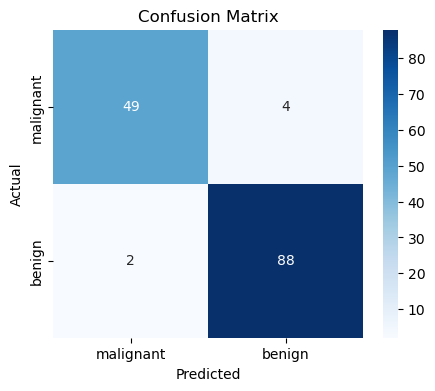

In [58]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=data.target_names,
            yticklabels=data.target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## 7. Feature Importance

Random Forest provides **global feature importance**.
This tells us which features were most useful overall.


In [62]:
importances = pd.Series(
    rf_baseline.feature_importances_,
    index=X.columns
).sort_values(ascending=False)
importances.head(10)

worst area              0.149674
worst concave points    0.127189
mean concave points     0.104650
worst radius            0.086963
worst perimeter         0.080299
mean perimeter          0.080037
mean concavity          0.055420
mean radius             0.053665
mean area               0.044062
area error              0.024557
dtype: float64


## 8. Why Hyperparameter Tuning Matters

Problems with default settings:
- Trees may be too deep
- Model may overfit
- Training may be unnecessarily slow

We tune **structure**, not vanity metrics.



## 9. Key Hyperparameters

- n_estimators: number of trees
- max_depth: tree depth
- min_samples_split: minimum samples to split
- max_features: features per split


In [64]:
param_grid={
    "n_estimators": [100,150,175,200],
    "max_depth": [None, 5, 10, 15],
    "min_samples_split": [2,3,5],
    "max_features": ["sqrt", "log2"]
}


## 10. GridSearchCV for Tuning


In [66]:
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [100, 150, 175, 200]},
             scoring='f1')

In [68]:
print("Best parameters found:")
print(grid_rf.best_params_)

Best parameters found:
{'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 100}



## 11. Evaluating the Tuned Model


In [70]:
#Evaluating the Tuned Model
best_rf = grid_rf.best_estimator_
y_pred_best = best_rf.predict(X_test)

print(classification_report(y_test, y_pred_best, target_names=data.target_names))


              precision    recall  f1-score   support

   malignant       0.96      0.92      0.94        53
      benign       0.96      0.98      0.97        90

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143

